# 1. 환경설정

- 파이토치
- 한국어를 영어로 번역하는 Seq2Seq(기본 모델, Attention 적용 모델)을 구현
- JSON 파일(train_set.json, valid_set.json) 형식
- 데이터셋 각 항목은 한국어 문장("ko")과 영어 번역문("mt")으로 구성
- 적절한 토크나이저를 선택하여 한국어, 영어 문장을 토큰화
- 필요한 경우 SOS, EOS, PAD, UNK 등의 특수 토큰을 정의
- 한국어와 영어 각각의 어휘 사전 구성
- Seq2Seq 모델: GRU 기반의 Encoder-Decoder 모델을 구현하고, Teacher Forcing 기법을 적용해 학습
- Attention 모델: Attention(Bahdanau 혹은 Luong)을 적용한 디코더를 구현
- 무작위 문장 쌍에 대해 모델의 번역 결과를 출력
- 다양한 평가 지표(예: BLEU 점수) 도입

In [1]:
""" 디렉토리 설정 """
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive; drive.mount('/content/drive')
    import drive.MyDrive.develop.config_my_path as cc
    cc.dir('projects/side/250625-250702_machine-translator/machine-translator')


""" 라이브러리 설정 """
# 시스템 & 유틸
import os
import json
import random
import math
from collections import Counter
from pathlib import Path
from tqdm import tqdm

# 데이터 처리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# NLP 라이브러리
import nltk
nltk.download('punkt')
!pip install kiwipiepy
!pip install konlpy
import spacy
from kiwipiepy import Kiwi
from konlpy.tag import Mecab
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Mounted at /content/drive
/content/drive/MyDrive/develop/projects/side/250625-250702_machine-translator/machine-translator


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 68.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 114.0 MB/s eta 0:00:00
  Created wheel for kiwipiepy_model: filename=kiwipiepy_model-0.21.0-py3-none-any.whl size=35593192 sha256=52473ec03e60ca662f2943ac0eec3279a17208c3b08599982b1b0171d7690f3a
  Stored in directory: /root/.cache/pip/wheels/b0/16/3d/95053ab5298f0f0f22ffea6de0200b6f24bffb73cab4c1a828
Successfully built kiwipiepy_model
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 43.0 MB/s eta 0:00:00


# 2. EDA

Train datas: 1200000
Valid datas: 150000
────────────────────────────────────────
KO: 원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.
MT: If you reply to the color you want, we will start making it right away.
────────────────────────────────────────
JSON 파일 구성: {'sn': 'INTSALDSUT062119042703238', 'data_set': '일상생활및구어체', 'domain': '해외영업', 'subdomain': '도소매유통', 'ko_original': '원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.', 'ko': '원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.', 'mt': 'If you reply to the color you want, we will start making it right away.', 'en': 'If you reply to the color you want, we will start making it right away.', 'source_language': 'ko', 'target_language': 'en', 'word_count_ko': 7, 'word_count_en': 15, 'word_ratio': 2.143, 'file_name': 'INTSAL_DSUT.xlsx', 'source': '크라우드소싱', 'license': 'open', 'style': '구어체', 'included_unknown_words': False, 'ner': None}
────────────────────────────────────────
Train set
KO Avg Length: 27
EN Avg Length: 54
KO Max Length: 297
EN Max Length: 377
─────────────────────────────

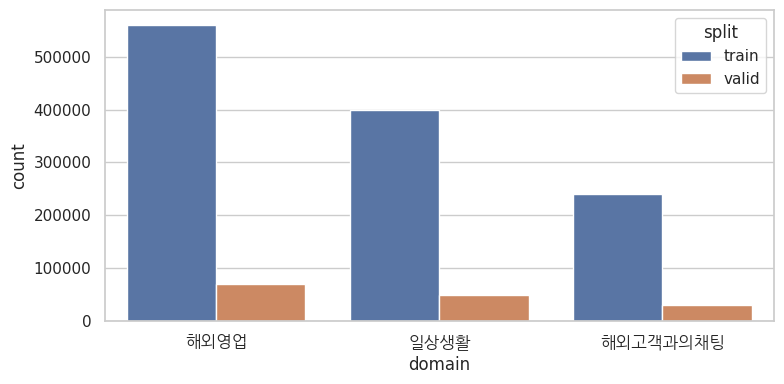

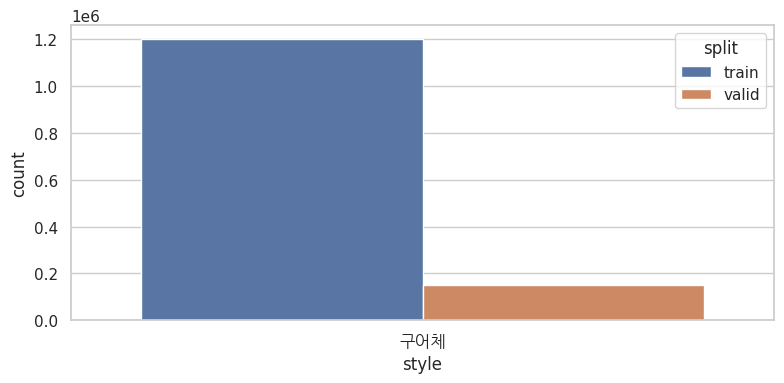

In [2]:
""" JSON 파일 로드 """
# JSON 파일 로드 함수
def load_json_data(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data['data']

train_path = 'train_set.json'
valid_path = 'valid_set.json'

train_data = load_json_data(train_path)
valid_data = load_json_data(valid_path)

# JSON 기본 정보 확인
print(f"Train datas: {len(train_data)}")
print(f"Valid datas: {len(valid_data)}")
print("────────────────────────────────────────")
print("KO:", train_data[0]['ko'])
print("MT:", train_data[0]['mt'])
print("────────────────────────────────────────")
print(f"JSON 파일 구성: {train_data[0]}")
print("────────────────────────────────────────")


""" JSON 파일 EDA(수치) """
# 문장 길이 측정
def get_sentence_lengths(data):
    ko_lens = [len(item['ko']) for item in data]
    en_lens = [len(item['mt']) for item in data]
    return ko_lens, en_lens

ko_lengths_train, en_lengths_train = get_sentence_lengths(train_data)
print("Train set")
print(f"KO Avg Length: {np.mean(ko_lengths_train):.0f}")
print(f"EN Avg Length: {np.mean(en_lengths_train):.0f}")
print(f"KO Max Length: {max(ko_lengths_train)}")
print(f"EN Max Length: {max(en_lengths_train)}")
print("────────────────────────────────────────")

ko_lengths_valid, en_lengths_valid = get_sentence_lengths(valid_data)
print("Valid set")
print(f"KO Avg Length: {np.mean(ko_lengths_valid):.0f}")
print(f"EN Avg Length: {np.mean(en_lengths_valid):.0f}")
print(f"KO Max Length: {max(ko_lengths_valid)}")
print(f"EN Max Length: {max(en_lengths_valid)}")
print("────────────────────────────────────────")


""" JSON 파일 EDA(시각화) """
# 시각화를 위한 데이터프레임 변환
train_df = pd.DataFrame(train_data)
train_df['split'] = 'train'
valid_df = pd.DataFrame(valid_data)
valid_df['split'] = 'valid'
df = pd.concat([train_df, valid_df], ignore_index=True)

# 시각화 셋팅
sns.set(style="whitegrid")
font_path = "NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)
font_name = fontprop.get_name()

# Domain 분포 시각화
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='domain', hue='split', order=df['domain'].value_counts().index)
plt.xticks(fontproperties=fontprop)
plt.tight_layout()
plt.show()

# Style 분포 시각화
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='style', hue='split', order=df['style'].value_counts().index)
plt.xticks(fontproperties=fontprop)
plt.tight_layout()
plt.show()

# 3. 전처리

In [ ]:
""" 전처리 클래스 및 함수 생성 """
# 하이퍼파라미터 설정
SPECIAL_TOKENS = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
TRAIN_JSON   = "train_set.json"
VALID_JSON   = "valid_set.json"
TRAIN_CACHE  = "tokenized_train.pt"
VALID_CACHE  = "tokenized_valid.pt"
SMOKE_RATIO  = 0.1 # 전체 데이터의 5% 만 전처리
MIN_FREQ     = 2
BATCH_SIZE   = 256


# 토크나이저 설정
class Tokenizer:
    def __init__(self):
        self.kiwi = Kiwi()
        self.en   = spacy.load("en_core_web_sm")
    def tokenize_ko(self, text):
        return [t.form for t in self.kiwi.tokenize(text)]
    def tokenize_en(self, text):
        return [t.text.lower() for t in self.en(text)]

# 단어사전 생성
def build_vocab(tokenized_sents, min_freq=MIN_FREQ):
    ctr    = Counter(tok for sent in tokenized_sents for tok in sent)
    tokens = [tok for tok, f in ctr.items() if f >= min_freq]
    vocab  = {tok: idx for idx, tok in enumerate(tokens, start=len(SPECIAL_TOKENS))}
    return {**SPECIAL_TOKENS, **vocab}

# 토큰을 ID로 변경
def encode(tokens, vocab, add_sos_eos=True):
    ids = [vocab.get(t, SPECIAL_TOKENS["<unk>"]) for t in tokens]
    if add_sos_eos:
        return [SPECIAL_TOKENS["<sos>"]] + ids + [SPECIAL_TOKENS["<eos>"]]
    return ids

# 패딩 입히기
def collate_fn(batch):
    ko_batch, en_batch = zip(*batch)
    ko_pad = pad_sequence(ko_batch, batch_first=True, padding_value=SPECIAL_TOKENS["<pad>"])
    en_pad = pad_sequence(en_batch, batch_first=True, padding_value=SPECIAL_TOKENS["<pad>"])
    return ko_pad, en_pad

# Dataset 생성
class IndexedDataset(Dataset):
    def __init__(self, indexed):
        self.indexed = indexed
    def __len__(self):
        return len(self.indexed)
    def __getitem__(self, idx):
        item = self.indexed[idx]
        return torch.tensor(item["ko"]), torch.tensor(item["mt"])

# 전처리 데이터 저장 및 로드
def process_split(json_path, cache_path, tokenizer, ratio, ko_vocab=None, en_vocab=None, build_vocab_flag=False):
    if os.path.exists(cache_path):
        print(f"[SKIP] '{cache_path}' already exists")
        return torch.load(cache_path)

    data = json.load(open(json_path, "r", encoding="utf-8"))["data"]
    if 0 < ratio < 1:
        random.seed(42)
        data = random.sample(data, int(len(data) * ratio))

    ko_sents = [d["ko"] for d in data]
    en_sents = [d["mt"] for d in data]

    ko_tok = [tokenizer.tokenize_ko(s) for s in tqdm(ko_sents, desc=f"Tokenizing KO ({Path(json_path).name})")]
    en_tok = [tokenizer.tokenize_en(s) for s in tqdm(en_sents, desc=f"Tokenizing EN ({Path(json_path).name})")]

    if build_vocab_flag:
        ko_vocab = build_vocab(ko_tok)
        en_vocab = build_vocab(en_tok)

    indexed = []
    for ks, es in tqdm(zip(ko_tok, en_tok), total=len(ko_tok), desc=f"Encoding ({Path(json_path).name})"):
        indexed.append({"ko": encode(ks, ko_vocab), "mt": encode(es, en_vocab)})

    torch.save((indexed, ko_vocab, en_vocab), cache_path)
    print(f"[SAVED] '{cache_path}'")
    return indexed, ko_vocab, en_vocab


""" 전처리 실행 """
tokenizer = Tokenizer()

# Train: vocab 생성 포함
train_indexed, ko_vocab, en_vocab = process_split(
    json_path = TRAIN_JSON,
    cache_path = TRAIN_CACHE,
    tokenizer = tokenizer,
    ratio = SMOKE_RATIO,
    ko_vocab = None,
    en_vocab = None,
    build_vocab_flag = True
)

# Valid: 기존 vocab 재사용
valid_indexed, _, _ = process_split(
    json_path = VALID_JSON,
    cache_path = VALID_CACHE,
    tokenizer = tokenizer,
    ratio = SMOKE_RATIO,
    ko_vocab = ko_vocab,
    en_vocab = en_vocab,
    build_vocab_flag = False
)

# DataLoader 준비
train_loader = DataLoader(
    IndexedDataset(train_indexed),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    IndexedDataset(valid_indexed),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

print(f"train batches: {len(train_loader)}, valid batches: {len(valid_loader)}")


Encoding (train_set.json): 100%|██████████| 120000/120000 [00:01<00:00, 61499.48it/s]


[SAVED] 'tokenized_train.pt'


Encoding (valid_set.json): 100%|██████████| 15000/15000 [00:00<00:00, 118511.29it/s]


[SAVED] 'tokenized_valid.pt'
train batches: 469, valid batches: 59


# 4. 모델 구현

## GRU 기반 Seq2Seq

In [ ]:
""" Seq2Seq without Attention """
# 인코더 클래스
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        return hidden

# 디코더 클래스
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, context):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        emb_con = torch.cat((embedded, context.unsqueeze(0)), dim=2)
        output, hidden = self.rnn(emb_con, hidden)
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden

# 인코더 + 디코더 클래스
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        context = self.encoder(src)
        hidden = context
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context[-1])
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

## GRU 기반 Seq2Seq with Bahdanau Attention

In [ ]:
""" Seq2Seq with Bahdanau Attention """
# 인코더 클래스
class AttnEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden

# 어텐션 클래스
class BahdanauAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

# 디코더 클래스
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden.squeeze(0)

# 인코더 + 디코더 클래스
class AttnSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

## 모델 인스턴스 생성

In [ ]:
""" 하이퍼파라미터 설정 """
# 공통 설정
INPUT_DIM = len(ko_vocab)
OUTPUT_DIM = len(en_vocab)
ENC_EMB_DIM = 256   # 인코더 임베딩 차원
DEC_EMB_DIM = 256   # 디코더 임베딩 차원
DROPOUT = 0.3

# Seq2Seq without Attention 설정
HID_DIM = 512       # GRU 히든 차원
N_LAYERS = 2        # GRU 레이어 수

# Seq2Seq with Bahdanau Attention 설정
ENC_HID_DIM = 512   # 인코더 GRU 히든 차원
DEC_HID_DIM = 512   # 디코더 GRU 히든 차원


""" 모델 인스턴스 생성 """
# Basic Seq2Seq 모델 객체
basic_encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
basic_decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model_basic = Seq2Seq(basic_encoder, basic_decoder, device).to(device)


# Attention Seq2Seq 모델 객체
attn_encoder = AttnEncoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DROPOUT)
attention = BahdanauAttention(ENC_HID_DIM, DEC_HID_DIM)
attn_decoder = AttnDecoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DROPOUT, attention)
model_attn = AttnSeq2Seq(attn_encoder, attn_decoder, device).to(device)


""" 파라미터 수 확인 """
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Basic Seq2Seq model parameters: {count_parameters(model_basic):,}")
print(f"Attention Seq2Seq model parameters: {count_parameters(model_attn):,}")


Basic Seq2Seq model parameters: 22,242,017
Attention Seq2Seq model parameters: 41,992,673


# 5. 모델 훈련

In [ ]:
""" 옵티마이저 & 손실함수 설정 """
# Basic Seq2Seq
opt_basic = optim.Adam(model_basic.parameters(), lr=0.001)
criterion_basic = nn.CrossEntropyLoss(ignore_index=SPECIAL_TOKENS['<pad>'])

# Attention Seq2Seq
opt_attn = optim.Adam(model_attn.parameters(), lr=0.001)
criterion_attn = nn.CrossEntropyLoss(ignore_index=SPECIAL_TOKENS['<pad>'])

epochs = 20


""" 모델 학습 함수 """
def train_model(model, train_loader, valid_loader, optimizer, criterion, epochs, device):
    model_name = model.__class__.__name__
    best_valid_loss = float('inf')

    print(f"\n========== Model: {model_name} ==========")

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        print(f"\n--- Epoch {epoch+1}/{epochs} ---")

        # Train set 진행
        for i, (src, trg) in enumerate(tqdm(train_loader, desc="Training")):
            src, trg = src.to(device).T, trg.to(device).T

            output = model(src, trg, teacher_forcing_ratio=0.5)
            output_dim = output.shape[-1]
            output_reshaped = output[1:].reshape(-1, output_dim)
            trg_reshaped = trg[1:].reshape(-1)

            loss = criterion(output_reshaped, trg_reshaped)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Valid set 진행
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for i, (src, trg) in enumerate(tqdm(valid_loader, desc="Evaluating")):
                src, trg = src.to(device).T, trg.to(device).T
                output = model(src, trg, 0)
                output_dim = output.shape[-1]
                output_reshaped = output[1:].reshape(-1, output_dim)
                trg_reshaped = trg[1:].reshape(-1)

                loss = criterion(output_reshaped, trg_reshaped)

                total_valid_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_valid_loss = total_valid_loss / len(valid_loader)

        print(f'\tTrain Loss: {avg_train_loss:.3f} | Train PPL: {math.exp(avg_train_loss):7.3f}')
        print(f'\tValid Loss: {avg_valid_loss:.3f} | Valid PPL: {math.exp(avg_valid_loss):7.3f}')

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save(model.state_dict(), f'best-model-{model_name}.pth')


""" 모델 학습 실행 """
# Basic 모델 훈련
train_model(model_basic, train_loader, valid_loader, opt_basic, criterion_basic, epochs, device)

# Attention 모델 훈련
train_model(model_attn, train_loader, valid_loader, opt_attn, criterion_attn, epochs, device)


========== Model: Seq2Seq ==========

--- Epoch 1/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


	Train Loss: 5.556 | Train PPL: 258.754
	Valid Loss: 5.382 | Valid PPL: 217.478

--- Epoch 2/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.12it/s]


	Train Loss: 4.803 | Train PPL: 121.933
	Valid Loss: 5.041 | Valid PPL: 154.670

--- Epoch 3/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


	Train Loss: 4.361 | Train PPL:  78.308
	Valid Loss: 4.759 | Valid PPL: 116.606

--- Epoch 4/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]


	Train Loss: 4.021 | Train PPL:  55.767
	Valid Loss: 4.589 | Valid PPL:  98.361

--- Epoch 5/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.09it/s]


	Train Loss: 3.770 | Train PPL:  43.394
	Valid Loss: 4.502 | Valid PPL:  90.188

--- Epoch 6/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


	Train Loss: 3.552 | Train PPL:  34.898
	Valid Loss: 4.447 | Valid PPL:  85.376

--- Epoch 7/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]


	Train Loss: 3.391 | Train PPL:  29.700
	Valid Loss: 4.401 | Valid PPL:  81.573

--- Epoch 8/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.08it/s]


	Train Loss: 3.263 | Train PPL:  26.125
	Valid Loss: 4.330 | Valid PPL:  75.911

--- Epoch 9/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.01it/s]


	Train Loss: 3.142 | Train PPL:  23.151
	Valid Loss: 4.291 | Valid PPL:  73.033

--- Epoch 10/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.09it/s]


	Train Loss: 3.042 | Train PPL:  20.946
	Valid Loss: 4.278 | Valid PPL:  72.084

--- Epoch 11/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]


	Train Loss: 2.935 | Train PPL:  18.816
	Valid Loss: 4.297 | Valid PPL:  73.512

--- Epoch 12/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]


	Train Loss: 2.873 | Train PPL:  17.688
	Valid Loss: 4.272 | Valid PPL:  71.689

--- Epoch 13/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


	Train Loss: 2.799 | Train PPL:  16.432
	Valid Loss: 4.235 | Valid PPL:  69.094

--- Epoch 14/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]


	Train Loss: 2.737 | Train PPL:  15.448
	Valid Loss: 4.317 | Valid PPL:  74.992

--- Epoch 15/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


	Train Loss: 2.679 | Train PPL:  14.575
	Valid Loss: 4.310 | Valid PPL:  74.471

--- Epoch 16/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.03it/s]


	Train Loss: 2.628 | Train PPL:  13.851
	Valid Loss: 4.303 | Valid PPL:  73.924

--- Epoch 17/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]


	Train Loss: 2.586 | Train PPL:  13.280
	Valid Loss: 4.289 | Valid PPL:  72.905

--- Epoch 18/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]


	Train Loss: 2.556 | Train PPL:  12.883
	Valid Loss: 4.289 | Valid PPL:  72.920

--- Epoch 19/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.05it/s]


	Train Loss: 2.505 | Train PPL:  12.245
	Valid Loss: 4.328 | Valid PPL:  75.791

--- Epoch 20/20 ---


Evaluating: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]


	Train Loss: 2.492 | Train PPL:  12.091
	Valid Loss: 4.279 | Valid PPL:  72.156

========== Model: AttnSeq2Seq ==========

--- Epoch 1/20 ---


Evaluating: 100%|██████████| 59/59 [00:19<00:00,  3.09it/s]


	Train Loss: 4.782 | Train PPL: 119.332
	Valid Loss: 4.432 | Valid PPL:  84.091

--- Epoch 2/20 ---


Evaluating: 100%|██████████| 59/59 [00:19<00:00,  3.10it/s]


	Train Loss: 3.492 | Train PPL:  32.866
	Valid Loss: 4.076 | Valid PPL:  58.913

--- Epoch 3/20 ---


Evaluating: 100%|██████████| 59/59 [00:18<00:00,  3.11it/s]


	Train Loss: 2.954 | Train PPL:  19.180
	Valid Loss: 3.944 | Valid PPL:  51.648

--- Epoch 4/20 ---


Evaluating: 100%|██████████| 59/59 [00:18<00:00,  3.11it/s]


	Train Loss: 2.631 | Train PPL:  13.892
	Valid Loss: 4.029 | Valid PPL:  56.229

--- Epoch 5/20 ---


Evaluating: 100%|██████████| 59/59 [00:18<00:00,  3.11it/s]


	Train Loss: 2.427 | Train PPL:  11.328
	Valid Loss: 3.984 | Valid PPL:  53.744

--- Epoch 6/20 ---


Evaluating: 100%|██████████| 59/59 [00:19<00:00,  3.10it/s]


	Train Loss: 2.300 | Train PPL:   9.975
	Valid Loss: 4.046 | Valid PPL:  57.175

--- Epoch 7/20 ---


Evaluating: 100%|██████████| 59/59 [00:18<00:00,  3.11it/s]


	Train Loss: 2.209 | Train PPL:   9.104
	Valid Loss: 3.968 | Valid PPL:  52.903

--- Epoch 8/20 ---


Evaluating: 100%|██████████| 59/59 [00:18<00:00,  3.11it/s]


	Train Loss: 2.106 | Train PPL:   8.217
	Valid Loss: 4.050 | Valid PPL:  57.382

--- Epoch 9/20 ---


Evaluating: 100%|██████████| 59/59 [00:18<00:00,  3.11it/s]


	Train Loss: 2.030 | Train PPL:   7.614
	Valid Loss: 4.121 | Valid PPL:  61.640

--- Epoch 10/20 ---


Evaluating: 100%|██████████| 59/59 [00:18<00:00,  3.11it/s]


	Train Loss: 1.971 | Train PPL:   7.180
	Valid Loss: 4.084 | Valid PPL:  59.384

--- Epoch 11/20 ---


Evaluating: 100%|██████████| 59/59 [00:18<00:00,  3.11it/s]


	Train Loss: 1.923 | Train PPL:   6.843
	Valid Loss: 4.178 | Valid PPL:  65.259

--- Epoch 12/20 ---


Evaluating: 100%|██████████| 59/59 [00:19<00:00,  3.10it/s]


	Train Loss: 1.859 | Train PPL:   6.415
	Valid Loss: 4.225 | Valid PPL:  68.364

--- Epoch 13/20 ---


Evaluating: 100%|██████████| 59/59 [00:19<00:00,  3.10it/s]


	Train Loss: 1.824 | Train PPL:   6.194
	Valid Loss: 4.187 | Valid PPL:  65.830

--- Epoch 14/20 ---


Evaluating: 100%|██████████| 59/59 [00:18<00:00,  3.11it/s]


	Train Loss: 1.794 | Train PPL:   6.015
	Valid Loss: 4.267 | Valid PPL:  71.341

--- Epoch 15/20 ---


Evaluating: 100%|██████████| 59/59 [00:18<00:00,  3.12it/s]


	Train Loss: 1.768 | Train PPL:   5.859
	Valid Loss: 4.304 | Valid PPL:  73.960

--- Epoch 16/20 ---


Evaluating: 100%|██████████| 59/59 [00:19<00:00,  3.09it/s]


	Train Loss: 1.754 | Train PPL:   5.779
	Valid Loss: 4.227 | Valid PPL:  68.533

--- Epoch 17/20 ---


Evaluating: 100%|██████████| 59/59 [00:19<00:00,  3.10it/s]


	Train Loss: 1.712 | Train PPL:   5.541
	Valid Loss: 4.337 | Valid PPL:  76.470

--- Epoch 18/20 ---


Evaluating: 100%|██████████| 59/59 [00:19<00:00,  3.10it/s]


	Train Loss: 1.689 | Train PPL:   5.415
	Valid Loss: 4.323 | Valid PPL:  75.413

--- Epoch 19/20 ---


Evaluating: 100%|██████████| 59/59 [00:19<00:00,  3.10it/s]


	Train Loss: 1.666 | Train PPL:   5.291
	Valid Loss: 4.369 | Valid PPL:  78.992

--- Epoch 20/20 ---


Evaluating: 100%|██████████| 59/59 [00:19<00:00,  3.09it/s]

	Train Loss: 1.640 | Train PPL:   5.154
	Valid Loss: 4.374 | Valid PPL:  79.368


# 6. 모델 평가

In [ ]:
""" 일부 샘플 BLEU 점수로 평가 """
def evaluate_and_show_samples(model, data_loader, device, num_samples=1):
    ko_idx2word = {idx: word for word, idx in ko_vocab.items()}
    en_idx2word = {idx: word for word, idx in en_vocab.items()}

    model.eval()
    src_batch, trg_batch = next(iter(data_loader))
    src_batch, trg_batch = src_batch.to(device), trg_batch.to(device)
    src_tensors, trg_tensors = src_batch.T, trg_batch.T

    with torch.no_grad():
        output = model(src_tensors, trg_tensors, teacher_forcing_ratio=0.0)
    pred_tensors = output.argmax(2).T

    print(f"\n[{model.__class__.__name__}] Translation")

    for i in range(num_samples):
        src, trg, pred = src_batch[i], trg_batch[i], pred_tensors[i]

        src_sent = [ko_idx2word.get(idx.item(), "<unk>") for idx in src if idx.item() != SPECIAL_TOKENS["<pad>"]]
        trg_sent = [en_idx2word.get(idx.item(), "<unk>") for idx in trg if idx.item() != SPECIAL_TOKENS["<pad>"]]
        pred_sent = [en_idx2word.get(idx.item(), "<unk>") for idx in pred if idx.item() != SPECIAL_TOKENS["<pad>"]]

        # 예측 결과에서 <eos> 토큰 이후는 잘라내기
        try:
            eos_index = pred_sent.index('<eos>')
            pred_sent = pred_sent[:eos_index]
        except ValueError:
            pass

        clean_trg = [word for word in trg_sent if word not in ['<sos>', '<eos>']]
        bleu = sentence_bleu([clean_trg], pred_sent, smoothing_function=SmoothingFunction().method4)

        print("-" * 60)
        print(f"Source  : {' '.join(src_sent[1:-1])}") # <sos>, <eos> 제외
        print(f"Target  : {' '.join(clean_trg)}")
        print(f"Predict : {' '.join(pred_sent)}")
        print(f"BLEU    : {bleu*100:.2f}")


""" 평가 실행 """
models_to_evaluate = [
    (model_basic, 'best-model-Seq2Seq.pth'),
    (model_attn, 'best-model-AttnSeq2Seq.pth')
]

for model, model_path in models_to_evaluate:
    model.load_state_dict(torch.load(model_path, map_location=device))
    evaluate_and_show_samples(model, valid_loader, device, num_samples=1)


[Seq2Seq] Translation
------------------------------------------------------------
Source  : 저 가 New York 에 대하 어 잘 모르 어 호텔 을 예약 하 지 못 하 었 습니다 .
Target  : i did n't know much about new york so i could n't book the hotel .
Predict : i did n't know about the hotel , so i did n't know about a reservation .
BLEU    : 20.95

[AttnSeq2Seq] Translation
------------------------------------------------------------
Source  : 저 가 New York 에 대하 어 잘 모르 어 호텔 을 예약 하 지 못 하 었 습니다 .
Target  : i did n't know much about new york so i could n't book the hotel .
Predict : i did n't make a reservation for the i am not familiar .
BLEU    : 9.19


In [ ]:
""" 신규 입력 텍스트 번역 """
def translate_sentence(sentence_str, model, tokenizer, ko_vocab, en_vocab, device, max_len=50):
    model.eval()

    tokens = tokenizer.tokenize_ko(sentence_str)
    tokens = ['<sos>'] + tokens + ['<eos>']
    src_indexes = [ko_vocab.get(token, ko_vocab['<unk>']) for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    with torch.no_grad():
        # 모델 종류에 따라 다르게 처리
        if isinstance(model, Seq2Seq):
            hidden = model.encoder(src_tensor)
            context = hidden
        else:
            encoder_outputs, hidden = model.encoder(src_tensor)

    trg_indexes = [en_vocab['<sos>']]
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            # 모델 종류에 따라 다르게 처리
            if isinstance(model, Seq2Seq):
                output, hidden = model.decoder(trg_tensor, hidden, context[-1])
            else:
                output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == en_vocab['<eos>']:
            break

    en_idx2word = {idx: word for word, idx in en_vocab.items()}
    trg_tokens = [en_idx2word.get(i, '<unk>') for i in trg_indexes]

    return trg_tokens[1:-1] # <sos>와 <eos> 제외


""" 번역 실행 """
my_sentence = ("관련 보고서를 금일 18시까지 보내주시길 바랍니다.")

print(f"My Sentence: [{my_sentence}]")
print("─" * 50)

for model, model_path in models_to_evaluate:
    model.eval()
    translated_tokens = translate_sentence(my_sentence, model, tokenizer, ko_vocab, en_vocab, device)
    translated_sentence = " ".join(translated_tokens)
    print(f"[{model.__class__.__name__} Translation] {translated_sentence}")

My Sentence: [관련 보고서를 금일 18시까지 보내주시길 바랍니다.]
──────────────────────────────────────────────────
[Seq2Seq Translation] please send me the relevant of .
[AttnSeq2Seq Translation] please send us the relevant to to the .
